In [1]:
using DifferentialEquations
using DiffEqSensitivity, ForwardDiff
using LaTeXStrings
using GRUtils

In [2]:
Eaf = Array([0.00, 0.00, 0.00, 0.36, 0.59, 0.31, 0.30, 0.54, 0.62, 0.77, 0.76, 0.10, 0.90, 0.96, 0.00, 0.00, 1.36])
Ear = Array([0.42, 0.57, 0.58, 1.40, 1.10, 0.95, 1.19, 1.72, 0.83, 0.89, 0.00, 0.00, 0.00, 0.00, 1.43, 1.18, 0.00])
Af = Array([1.87e8, 1.87e8, 1.87e8, 8.03e12, 1.17e13, 1.28e13, 1.14e13, 1.09e13, 4.10e13, 3.24e13, 1.00e13, 
            1.00e13, 1.00e13, 1.00e13, 1.00e13, 1.00e13, 1.00e13])
Ar = Array([1.00e13, 1.00e13, 1.00e13, 8.93e12, 1.78e13, 1.92e13, 7.14e12, 1.54e13, 1.53e13, 1.31e13, 2.85e8, 1.62e8, 
            1.59e8, 1.59e8, 1.00e13, 1.00e13, 2.14e8])


# # reaction conditions
# p_C3H6 = 0.1  # 0.01 - 0.5 bar
# p_O2 = 0.05  # 0.01 - 0.5 bar, https://doi.org/10.1016/j.jcat.2010.09.002
T= 350
times = 15.0  # end time for simulation
np = 1501  # number of points
kb = 8.617333262145e-5
kf0 = Af .* exp.(-Eaf ./ (T * kb))
kr0 = Ar .* exp.(-Ear ./ (T * kb))
K = kf0 ./ kr0

17-element Vector{Float64}:
   20.872546100528705
 3016.3405010833485
 4202.173967255303
    8.495813690618929e14
    1.4502492307661682e7
    1.0952244663399394e9
    1.0438608184641424e13
    6.9367803791872456e16
 2831.1269056019605
  132.18971425689134
    3.9961041134068033e-7
 2241.5496407486125
    6.905152211410761e-9
    9.445202678799137e-10
    3.900261523392704e20
    9.800588792613136e16
    1.2202480858241735e-15

#### Automatic Differentiation

In [3]:
function calc_rate(y, kf)
    global K
    kr = kf ./ K
    press = Array([0.1, 0.0, 0.0, 0.0, 0.05])
    fwd_factor = Array([press[1] * y[1], press[1] * y[1], press[1] * y[1], y[2] * y[5], y[3] * y[5], y[4] * y[5], y[6] * y[5], 
                        y[10] * y[7], y[8], y[9], y[12], y[11], y[13], y[14], y[16] * y[15], y[17] * y[17], y[16]])
    rev_factor = Array([y[2], y[3], y[4], y[6] * y[7], y[8], y[9], y[10] * y[1], y[11] * y[12], y[13] * y[1], y[14] * y[1], 
                        press[3] * y[15], press[2] * y[15], press[4] * y[15], press[4] * y[15], y[5] * y[17], y[16] * y[1], press[5] * y[1]])
    r = kf .* fwd_factor .- kr .* rev_factor
    return r
end


function calc_overall_rate(y, kf)
    global K
    kr = kf ./ K
    press = Array([0.1, 0.0, 0.0, 0.0, 0.05])
    r1 = y[13] * kf[13]
    r2 = y[14] * kf[14]
    r = r1 + r2
    return r
end


function state_eqn(dy, y, kf, t)
    r = calc_rate(y, kf)
    dy[1] = -r[1] - r[2] - r[3] + r[7] + r[9] + r[10] + r[16] + r[17]  # *
    dy[2] = r[1] - r[4]  # C3H6-1*
    dy[3] = r[2] - r[5]  # C3H6-2*
    dy[4] = r[3] - r[6]  # C3H6-3*
    dy[5] = -r[4] - r[5] - r[6] - r[7] + r[15]  # O*
    dy[6] =  r[4] - r[7] # C3H5*
    dy[7] =  r[4] - r[8] # OH*
    dy[8] =  r[5] - r[9] # OMP-1*
    dy[9] =  r[6] - r[10] # OMP-2*
    dy[10] = r[7] - r[8]  # C3H5O*
    dy[11] = r[8] - r[12]  # C3H4O*
    dy[12] = r[8] - r[11]  # H2O*
    dy[13] = r[9] - r[13]  # PO-1*
    dy[14] = r[10] - r[14]  # PO-2*
    dy[15] = r[11] + r[12] + r[13] + r[14] - r[15]  # v*
    dy[16] = -r[15] + r[16] - r[17]  # O2*
    dy[17] =  r[15] - 2 * r[16] # O-1*
end

state_eqn (generic function with 1 method)

In [4]:
tspan = (0., times + 1.0)
y0 = [0.68; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02; 0.02]
prob = ODEProblem(state_eqn, y0, tspan, kf0)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 16.0)
u0: 17-element Vector{Float64}:
 0.68
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02
 0.02

In [5]:
function rate_wrapper(p)
    p = exp.(p)
    nt = np
    _prob = remake(prob, p=p)
    theta_sol = Array(solve(_prob, Rodas4P(), saveat=LinRange(0., times, np), sensealg=ForwardDiffSensitivity(), atol=1e-8, rtol=1e-8))'  # [nt, nu]
    p_matrix = reshape(p, 1, size(p, 1))  # [1, np]
    p_repeat = repeat(p_matrix, nt, 1)  # [nt, np]
    r = Array{Real, 1}(undef, nt)
    for i in 1:nt
        r[i] = calc_overall_rate(theta_sol[i, :], p_repeat[i, :])
    end
    return log.(r)  # here, we take care with the second reaction
end

rate_wrapper (generic function with 1 method)

In [6]:
drdp = ForwardDiff.jacobian(rate_wrapper, log.(kf0))

1501×17 Matrix{Float64}:
  0.0          0.0         0.0          …   0.0           0.0
 -0.00399755   9.61583e-5  0.0042394        6.61814e-9   -0.000584464
 -0.00154971   8.31498e-5  0.00167367       4.60157e-9   -0.000261893
 -0.000524881  6.43145e-5  0.000701612      1.13217e-10  -0.000424031
 -0.000158407  5.66038e-5  0.00048945      -2.89243e-9   -0.000688568
 -3.91155e-5   5.38658e-5  0.000678655  …  -5.3132e-9    -0.00111
  5.09909e-6   5.26928e-5  0.00108609      -6.93231e-9   -0.00168479
  1.86994e-5   5.21626e-5  0.00164997      -7.61491e-9   -0.00236869
  2.31524e-5   5.18243e-5  0.00230405      -7.69637e-9   -0.00313166
  2.39026e-5   5.15637e-5  0.00302769      -7.53107e-9   -0.00395582
  2.3196e-5    5.13349e-5  0.00382354   …  -7.29258e-9   -0.00482865
  2.24219e-5   5.11078e-5  0.00465954      -7.08513e-9   -0.00575532
  2.15874e-5   5.08819e-5  0.00553211      -6.92101e-9   -0.00671127
  ⋮                                     ⋱   ⋮            
  0.0045958    8.01083e-5 

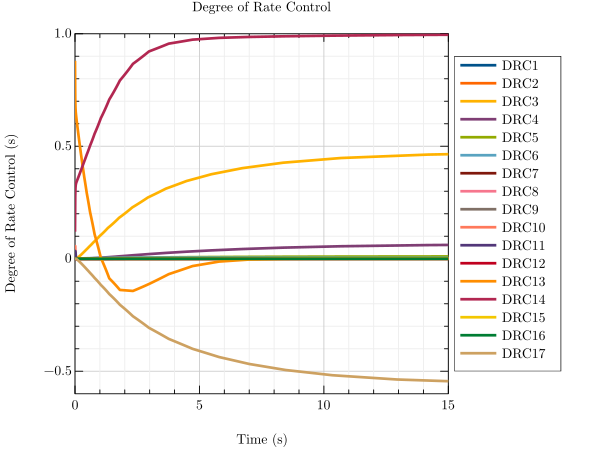

In [7]:
fig1 = Figure()
plot(LinRange(0., times, np), drdp, linewidth=3, xlabel = "Time (s)", ylabel = "Degree of Rate Control (s)", title = "Degree of Rate Control", dpi=300)
legend("DRC1", "DRC2", "DRC3", "DRC4", "DRC5", "DRC6", "DRC7", "DRC8", "DRC9", "DRC10", "DRC11", "DRC12", "DRC13", "DRC14", "DRC15", "DRC16", "DRC17", location=12)
display(fig1)

#### Transient FD

In [8]:
function trans_finite_forward(old_k, pert, prob, idx_k)
    new_k_1 = deepcopy(old_k)
    new_k_2 = deepcopy(old_k)
    new_k_1[idx_k] = old_k[idx_k] * (1 - pert)
    new_k_2[idx_k] = old_k[idx_k] * (1 + pert)
    _prob_1 = remake(prob, p=new_k_1)
    new_ode_sol_1 = solve(_prob_1, Rodas4P(), saveat=LinRange(0., times, np), atol=1e-8, rtol=1e-8)
    new_coverage_1 = Array(new_ode_sol_1)  # [nc, nt]
    new_rates_1 = Array{Float64, 1}(undef, size(new_coverage_1, 2))
    for it in 1:size(new_coverage_1, 2)
        new_rates_1[it] = calc_overall_rate(new_coverage_1[:, it], new_k_1)
    end
    
    _prob_2 = remake(prob, p=new_k_2)
    new_ode_sol_2 = solve(_prob_2, Rodas4P(), saveat=LinRange(0., times, np), atol=1e-8, rtol=1e-8)
    new_coverage_2 = Array(new_ode_sol_2)  # [nc, nt]
    new_rates_2 = Array{Float64, 1}(undef, size(new_coverage_2, 2))
    for it in 1:size(new_coverage_2, 2)
        new_rates_2[it] = calc_overall_rate(new_coverage_2[:, it], new_k_2)
    end
    
    delta_ln_rate = log.(new_rates_2) .- log.(new_rates_1)
    delta_ln_k = log.(new_k_2[idx_k]) - log.(new_k_1[idx_k])
    drc = delta_ln_rate ./ delta_ln_k
    return drc
end

trans_finite_forward (generic function with 1 method)

In [9]:
trans_cands = 10 .^(LinRange(-1., -14., 14))

fd_trans_drcs = Array{Float64, 3}(undef, size(trans_cands, 1), size(kf0, 1), np)

for (idx, c) in enumerate(trans_cands)
    for idx_k in 1:size(kf0, 1)
        fd_trans_drcs[idx, idx_k, :] = trans_finite_forward(kf0, c, prob, idx_k)
    end
end

#### Comparison

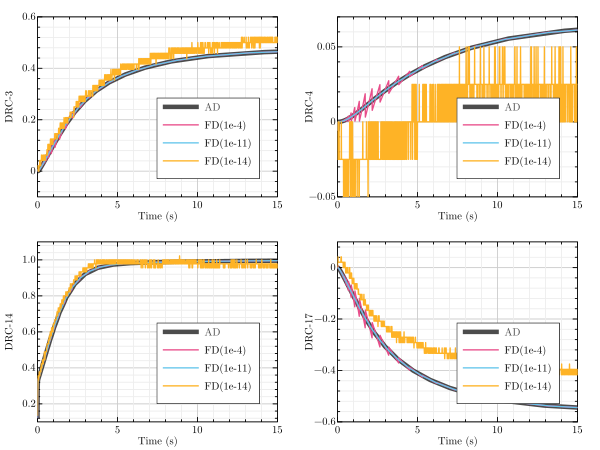

In [10]:
fig2 = Figure()

lw = 1.5
sub1 = subplot(2, 2, 1)
target_k = 3
# plot(LinRange(0., 0.02, 201), drdp[:, target_k], linewidth=3, linecolor=0x7F58AF, dpi=300, alpha=0.7)
plot(LinRange(0., times, np), drdp[:, target_k], linewidth=5, linecolor=0x000000, dpi=300, alpha=0.7)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[4, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-3", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[11, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-3", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[14, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-3", dpi=300, linecolor=0xFEB326)
legend("AD", "FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=4)

sub2 = subplot(2, 2, 2)
target_k = 4
plot(LinRange(0., times, np), drdp[:, target_k], linewidth=5, linecolor=0x000000, dpi=300, alpha=0.7)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[4, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-4", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[11, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-4", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[14, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-4", dpi=300, linecolor=0xFEB326)
hold(true)
legend("AD", "FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=4)

sub3 = subplot(2, 2, 3)
target_k = 14
plot(LinRange(0., times, np), drdp[:, target_k], linewidth=5, linecolor=0x000000, dpi=300, alpha=0.7)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[4, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-14", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[11, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-14", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[14, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-14", dpi=300, linecolor=0xFEB326)
hold(true)
legend("AD", "FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=4)

sub4 = subplot(2, 2, 4)
target_k = 17
plot(LinRange(0., times, np), drdp[:, target_k], linewidth=5, linecolor=0x000000, dpi=300, alpha=0.7)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[4, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-17", dpi=300, linecolor=0xE84D8A)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[11, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-17", dpi=300, linecolor=0x64C5EB)
hold(true)
plot(LinRange(0., times, np), (fd_trans_drcs[14, target_k, :]), linewidth=lw, xlabel = "Time (s)", ylabel = "DRC-17", dpi=300, linecolor=0xFEB326)
hold(true)
legend("AD", "FD(1e-4)", "FD(1e-11)", "FD(1e-14)", location=4)
display(fig2)

# savefig("case3-transient-350K.png")